<a href="https://colab.research.google.com/github/rts1988/Duolingo_spaced_repetition/blob/main/18_Q3and2_Duolingo_onlyderived_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <font color = 'cornflowerblue' size=4>Introduction</font>

In this notebook we will look at Q2 and Q3 modeling and testing with both student and word based features, except that the word vector features are removed.

Caveat: we only have data that spans 2 weeks. So we will need to leave the beginning few days out (as they will need to be the basis for the features based on student behavior, so as to prevent data leakage.)

Also, some of these features depend on the student's choices for that day. If they choose to spend a session reviewing old words vs learning new ones. 

The dataset is filtered to students who have logged in at least 11 number of days, and aggregate features are calculated for 1 to 10 days to see how well they separate performance of students. 




## <font color = 'cornflowerblue' size=4>Loading data and computing aggregates</font>

In [1]:
import warnings
warnings.filterwarnings('ignore')


import bz2
import pickle
import _pickle as cPickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

def decompress_pickle(file):
 data = bz2.BZ2File(file, 'rb')
 data = cPickle.load(data)
 return data

def compressed_pickle(title, data):  # do not add extension in filename
 with bz2.BZ2File(title + '.pbz2', 'w') as f: 
  cPickle.dump(data, f)

path_name = '/content/drive/MyDrive/'

Mounted at /content/drive


Loading q2train and validation sets:

In [2]:
Xq2train = decompress_pickle(path_name+"Q2TRAIN_ALLFX.pbz2") 
yq2train = decompress_pickle(path_name+"Q2TRAIN_ALLFy.pbz2") 

Xq2valid = decompress_pickle(path_name+"Q2VALID_ALLFX.pbz2") 
yq2valid = decompress_pickle(path_name+"Q2VALID_ALLFy.pbz2") 

In [3]:
Xq2train.shape, yq2train.shape, Xq2valid.shape, yq2valid.shape

((24409, 424), (24409,), (1344, 424), (1344,))

In [4]:
yq2train.sum()/yq2train.shape[0], yq2valid.sum()/yq2valid.shape[0]

(0.15318120365438978, 0.11383928571428571)

There is a minor differences in the class sample proportions in the training and validation sets. 

Removing the word vector features:

Isolating the desired columns

In [5]:
Xq2train.columns[0:11]

Index(['delta', 'history_seen', 'simoverdiff', 'history_frac',
       'avgp_forgot_day', 'avg_history_frac', 'numwordspracticed_day',
       'avgdelta_day', 'sf_length', 'L_dist_sf_noaccents_norm', 'EnglishIDF'],
      dtype='object')

Removing the word vectors from training and validation sets.

In [6]:
Xq2train = Xq2train.iloc[:,0:11]
Xq2train.shape

(24409, 11)

In [7]:
Xq2valid = Xq2valid.iloc[:,0:11]
Xq2valid.shape

(1344, 11)

Scaling the training and validation sets:

Since there's not too much data, no down-sampling will be donw. 

In [8]:
from sklearn.preprocessing import MinMaxScaler # used because sparse array not supported by MinMaxScaler
mm_scaler = MinMaxScaler()

mm_scaler.fit(Xq2train)
Xq2_train_mm = mm_scaler.transform(Xq2train)
Xq2_valid_mm = mm_scaler.transform(Xq2valid) # downsampled scaler is applied. 


In [9]:
Xq2_train_mm.shape

(24409, 11)

Training and validation sets are ready for modeling.

## <font color='cornflowerblue' size=4>Classical models</font>



### <font color='cornflowerblue' size=3>Logistic Regression</font>

In [10]:
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_validate # return scores for many metrics

from sklearn.metrics import make_scorer # to define a list of scoring metrics to use

from sklearn.model_selection import GridSearchCV # to search hyperparameters in a grid 

classweight_vals = ['balanced',{0:0.01,1:0.99}]
C_vals = [10**(-3),1,10**3]

para_dict =dict()
para_dict['class_weight'] = classweight_vals
para_dict['C'] = C_vals


# iterate over 
logreg = LogisticRegression(solver = 'lbfgs',max_iter=500)
scoring_metrics = ['accuracy','f1','average_precision','roc_auc','recall']

gridsearch_obj = GridSearchCV(logreg, param_grid = para_dict,cv=3,scoring = scoring_metrics, verbose=1,refit=False)

gridsearch_obj.fit(Xq2_train_mm,yq2train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=500),
             param_grid={'C': [0.001, 1, 1000],
                         'class_weight': ['balanced', {0: 0.01, 1: 0.99}]},
             refit=False,
             scoring=['accuracy', 'f1', 'average_precision', 'roc_auc',
                      'recall'],
             verbose=1)

In [11]:
gridcv = pd.DataFrame(gridsearch_obj.cv_results_)
np.around(gridcv[['param_class_weight','param_C','mean_fit_time',  'mean_score_time', 
       'mean_test_accuracy','mean_test_average_precision','mean_test_roc_auc','mean_test_f1','mean_test_recall']],2)

,param_class_weight,param_C,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_average_precision,mean_test_roc_auc,mean_test_f1,mean_test_recall
0,balanced,0.001,0.03,0.02,0.74,0.29,0.66,0.31,0.41
1,"{0: 0.01, 1: 0.99}",0.001,0.03,0.02,0.15,0.29,0.67,0.27,1.00
2,balanced,1,0.14,0.02,0.69,0.28,0.66,0.33,0.49
3,"{0: 0.01, 1: 0.99}",1,0.09,0.02,0.15,0.29,0.66,0.27,1.00
4,balanced,1000,0.21,0.04,0.69,0.28,0.66,0.33,0.50
5,"{0: 0.01, 1: 0.99}",1000,0.32,0.03,0.15,0.28,0.66,0.27,1.00


Overall model performance is somewhat improved by removing the morphological features and keeping the word based features. 

Taking the best model

Selecting the best model:
With a skewed class weight, recall is good, at the expense of accuracy. 

Precision is best at a 'balanced' class weight, but with an average recall of 0.51. 

Both models (index=0 and index = 3) will be refit to see how validation set does

In [12]:
logreg = LogisticRegression(solver = 'lbfgs',max_iter=5000,class_weight='balanced',C=.001)

logreg.fit(Xq2_train_mm,yq2train)

yvalid_preds_proba = logreg.predict_proba(Xq2_valid_mm)[:,1]
ytrain_preds_proba = logreg.predict_proba(Xq2_train_mm)[:,1]

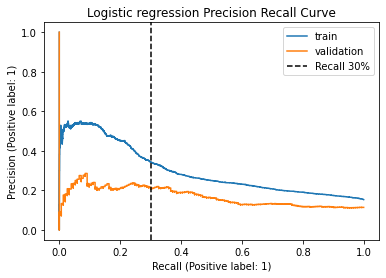

In [13]:
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve
precision3, recall3, thresholds3 = precision_recall_curve(yq2valid, yvalid_preds_proba)
precision3_t, recall3_t, thresholds3_t = precision_recall_curve(yq2train, ytrain_preds_proba)

plt.figure()
ax =plt.gca()
PrecisionRecallDisplay.from_predictions(yq2train,ytrain_preds_proba, ax=ax,label="train")
PrecisionRecallDisplay.from_predictions(yq2valid,yvalid_preds_proba, ax=ax,label="validation")

plt.title("Logistic regression Precision Recall Curve")
#precision_at_recall2 = np.interp(x= 0.3,xp = precision2[int(0.1*len(recall2)):int(0.8*len(recall2))],fp = recall2[int(0.1*len(recall2)):int(0.8*len(recall2))])
#precision_at_recall3 = np.interp(x= 0.3,xp = precision3[(precision3<0.9) & (precision3>0.05)],fp = recall3[(precision3<0.9) & (precision3>0.05)])
#precision_at_recall3_t = np.interp(x= 0.3,xp = precision3_t[(precision3_t<0.9) & (precision3_t>0.05)],fp = recall3_t[(precision3_t<0.9) & (precision3_t>0.05)])
#plt.axhline(precision_at_recall3,color='green',linestyle = '--',label = f"Precision at Recall 30% -Validation = {np.around(precision_at_recall3*100,2)}%")
#plt.axhline(precision_at_recall3_t,color='green',linestyle = '--',label = f"Precision at Recall 30% -Train= {np.around(precision_at_recall3_t*100,2)}%")
plt.axvline(0.3,color='black',linestyle='--',label = 'Recall 30%')
plt.legend()
plt.show()

The model might be overfitting to the training set. The validation set with new students does less well (drop in precision at recall = 30% to 21% from )

In [14]:
coefficients = pd.Series(logreg.coef_[0],index=Xq2train.columns)
coefficients.abs().sort_values(ascending=False).head(20)

avgp_forgot_day             0.445954
avg_history_frac            0.377341
history_frac                0.318716
numwordspracticed_day       0.244617
simoverdiff                 0.142974
sf_length                   0.071489
history_seen                0.033320
L_dist_sf_noaccents_norm    0.023005
EnglishIDF                  0.019765
delta                       0.011792
avgdelta_day                0.002331
dtype: float64

Average precision is around 0.21 for the validation set. There is no improvement over the word-based features alone. 

### <font color='cornflowerblue' size=3>Decision trees</font>

In [15]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier()

classweight_vals = ['balanced',{0:0.01,1:0.99}]
maxdepth_vals = [2,10]

para_dict =dict()
para_dict['class_weight'] = classweight_vals
para_dict['max_depth'] = maxdepth_vals


scoring_metrics = ['accuracy','f1','average_precision','roc_auc','recall']

gridsearch_obj = GridSearchCV(dtree, param_grid = para_dict,cv=3,scoring = scoring_metrics, verbose=3,refit=False)

gridsearch_obj.fit(Xq2train,yq2train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END class_weight=balanced, max_depth=2; accuracy: (test=0.837) average_precision: (test=0.160) f1: (test=0.052) recall: (test=0.029) roc_auc: (test=0.522) total time=   0.0s
[CV 2/3] END class_weight=balanced, max_depth=2; accuracy: (test=0.506) average_precision: (test=0.245) f1: (test=0.331) recall: (test=0.797) roc_auc: (test=0.674) total time=   0.0s
[CV 3/3] END class_weight=balanced, max_depth=2; accuracy: (test=0.523) average_precision: (test=0.242) f1: (test=0.317) recall: (test=0.723) roc_auc: (test=0.653) total time=   0.0s
[CV 1/3] END class_weight=balanced, max_depth=10; accuracy: (test=0.671) average_precision: (test=0.161) f1: (test=0.184) recall: (test=0.242) roc_auc: (test=0.493) total time=   0.1s
[CV 2/3] END class_weight=balanced, max_depth=10; accuracy: (test=0.560) average_precision: (test=0.190) f1: (test=0.274) recall: (test=0.541) roc_auc: (test=0.566) total time=   0.1s
[CV 3/3] END class_weig

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': ['balanced', {0: 0.01, 1: 0.99}],
                         'max_depth': [2, 10]},
             refit=False,
             scoring=['accuracy', 'f1', 'average_precision', 'roc_auc',
                      'recall'],
             verbose=3)

In [16]:
gridcv = pd.DataFrame(gridsearch_obj.cv_results_)
np.around(gridcv[['param_class_weight','param_max_depth','mean_fit_time',  'mean_score_time', 
       'mean_test_accuracy','mean_test_average_precision','mean_test_roc_auc','mean_test_f1','mean_test_recall']],2)

,param_class_weight,param_max_depth,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_average_precision,mean_test_roc_auc,mean_test_f1,mean_test_recall
0,balanced,2,0.02,0.02,0.62,0.22,0.62,0.23,0.52
1,balanced,10,0.07,0.02,0.63,0.19,0.56,0.26,0.43
2,"{0: 0.01, 1: 0.99}",2,0.02,0.02,0.16,0.20,0.59,0.27,1.00
3,"{0: 0.01, 1: 0.99}",10,0.07,0.02,0.27,0.20,0.56,0.25,0.80


A balanced class weight is explored futher:

Using max depth = 2
Using max depth = 3
Using max depth = 4
Using max depth = 5
Using max depth = 6
Using max depth = 7
Using max depth = 8
Using max depth = 9
Using max depth = 10
Using max depth = 11
Using max depth = 12
Using max depth = 13


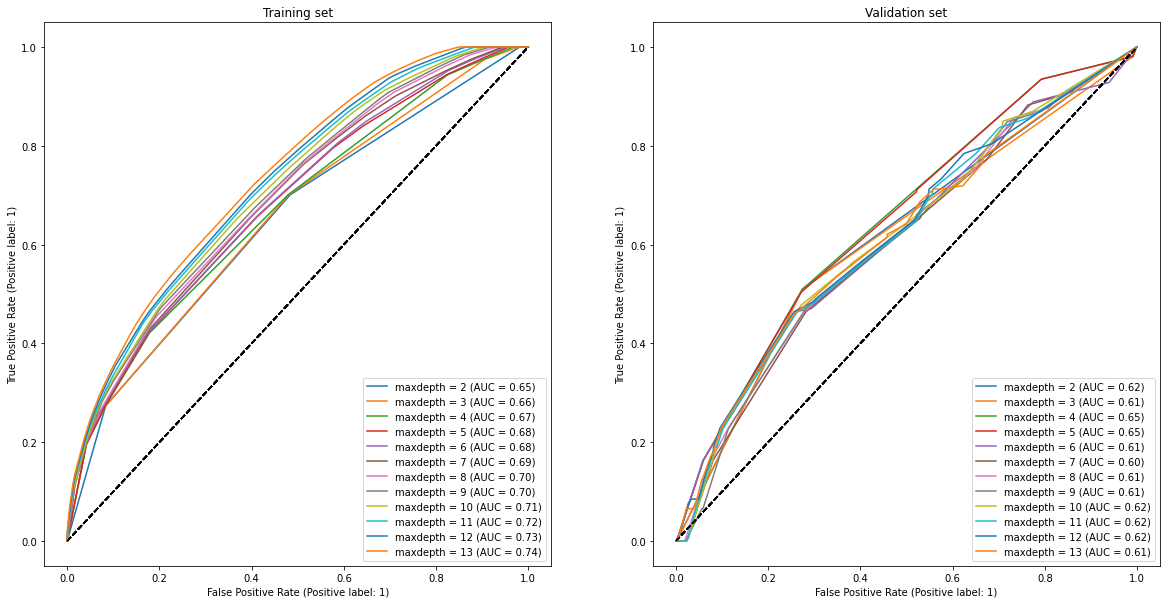

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,\
 roc_auc_score, plot_roc_curve,f1_score,\
  confusion_matrix, classification_report,\
  precision_recall_curve


# creating dictionaries to store metrics for different knn models
valid_acc = dict()
train_acc = dict()

valid_AUC = dict()
train_AUC = dict()

train_cm = dict()
valid_cm = dict()

train_f1 = dict()
valid_f1 = dict()

train_prc = dict()
valid_prc = dict()

train_proba1 = dict()
valid_proba1 = dict()


# create subplots
figs, axes = plt.subplots(1, 2, figsize=(20, 10))



depths = range(2,14)

for d in depths:
  print(f"Using max depth = {d}")
  DTCmodel = DecisionTreeClassifier(max_depth = d,class_weight={0:.01,1:0.99}) # intitalize a Decision tree classifier model with a new max depth
  DTCmodel.fit(Xq2train,yq2train) 

  # predicting on training and validation sets
  y_train_predicted = DTCmodel.predict(Xq2train) 
  y_valid_predicted = DTCmodel.predict(Xq2valid) 

  # soft predictions on training and validation data
  y_train_proba = DTCmodel.predict_proba(Xq2train) 
  y_valid_proba = DTCmodel.predict_proba(Xq2valid)

  # saving metrics for training and validayion data
  # calculate accuracy
  valid_acc[d] = accuracy_score(yq2valid, y_valid_predicted)
  train_acc[d] = accuracy_score(yq2train,y_train_predicted)

  # getting roc_auc scores for training and validation sets 
  valid_AUC[d] = roc_auc_score(yq2valid, y_valid_proba[:,1])
  train_AUC[d] = roc_auc_score(yq2train, y_train_proba[:,1])

  # getting confusion matrices
  valid_cm[d] = confusion_matrix(yq2valid, y_valid_predicted)
  train_cm[d] = confusion_matrix(yq2train, y_train_predicted)

  # F1 -scores
  valid_f1[d] = f1_score(yq2valid, y_valid_predicted)
  train_f1[d] = f1_score(yq2train, y_train_predicted)

  # precision recall curves
  valid_prc[d] = precision_recall_curve(yq2valid, y_valid_proba[:,1])
  train_prc[d] = precision_recall_curve(yq2train, y_train_proba[:,1])

  # saving probabilities of positive class
  valid_proba1[d] = y_valid_proba[:,1]
  train_proba1[d] = y_train_proba[:,1]

  # plot ROC curve for training and validation sets
  plot_roc_curve(DTCmodel, Xq2train, yq2train, ax=axes[0],name=f"maxdepth = {d}")
  plot_roc_curve(DTCmodel, Xq2valid, yq2valid, ax=axes[1],name=f"maxdepth = {d}")

  # Add line y=x and titls
  for axis_num, plot_title in enumerate(['Training set', 'Validation set']):
    axes[axis_num].plot([0,1], [0,1], color='black', linestyle='--')
    axes[axis_num].set_title(plot_title)

plt.show()



In [18]:
dtree_metrics = pd.DataFrame()
dtree_metrics['valid_accuracy'] = pd.Series(valid_acc)
dtree_metrics['train_accuracy'] = pd.Series(train_acc)
dtree_metrics['valid_AUC'] = pd.Series(valid_AUC)
dtree_metrics['train_AUC'] = pd.Series(train_AUC)
dtree_metrics['valid_f1'] = pd.Series(valid_f1)
dtree_metrics['train_f1'] = pd.Series(train_f1)
dtree_metrics = dtree_metrics.reset_index()
dtree_metrics['Max_depth'] = dtree_metrics['index']
dtree_metrics = dtree_metrics.drop('index',axis=1)
display(np.around(dtree_metrics,2))

,valid_accuracy,train_accuracy,valid_AUC,train_AUC,valid_f1,train_f1,Max_depth
0,0.11,0.17,0.62,0.65,0.20,0.27,2
1,0.11,0.17,0.61,0.66,0.20,0.27,3
2,0.11,0.18,0.65,0.67,0.20,0.27,4
3,0.11,0.19,0.65,0.68,0.20,0.27,5
4,0.16,0.19,0.61,0.68,0.20,0.28,6
5,0.24,0.20,0.60,0.69,0.21,0.28,7
6,0.25,0.21,0.61,0.70,0.21,0.28,8
7,0.28,0.22,0.61,0.70,0.22,0.28,9
8,0.30,0.23,0.62,0.71,0.22,0.28,10
9,0.31,0.25,0.62,0.72,0.22,0.29,11


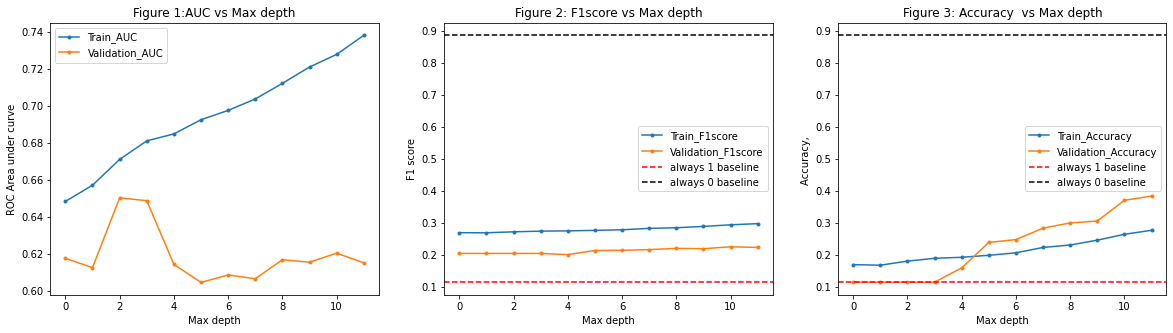

In [19]:
y_valid = yq2valid
y_train = yq2train

plt.subplots(1,3,figsize=(20,5))

plt.subplot(1,3,1)
plt.plot(dtree_metrics['train_AUC'],'.-',label='Train_AUC')
plt.plot(dtree_metrics['valid_AUC'],'.-',label='Validation_AUC')
plt.title("Figure 1:AUC vs Max depth")
plt.xlabel("Max depth")
plt.ylabel("ROC Area under curve")
plt.legend()

plt.subplot(1,3,2)
plt.plot(dtree_metrics['train_f1'],'.-',label='Train_F1score')
plt.plot(dtree_metrics['valid_f1'],'.-',label='Validation_F1score')
# getting accuracy for baseline model that always predicts 1 no matter what.
baseline1_f1 = accuracy_score(y_valid, [1]*y_valid.shape[0])
# getting accuracy for baseline model that always predicts 0 no matter what.
baseline0_f1 = accuracy_score(y_valid, [0]*y_valid.shape[0])
plt.axhline(baseline1_f1,color = 'red',linestyle = '--',label="always 1 baseline")
plt.axhline(baseline0_f1,color = 'black',linestyle = '--',label="always 0 baseline")
plt.xlabel("Max depth")
plt.ylabel("F1 score")
plt.title("Figure 2: F1score vs Max depth")
plt.legend()

plt.subplot(1,3,3)
plt.plot(dtree_metrics['train_accuracy'],'.-',label='Train_Accuracy')
plt.plot(dtree_metrics['valid_accuracy'],'.-',label='Validation_Accuracy')
# getting accuracy for baseline model that always predicts 1 no matter what.
baseline1_acc = accuracy_score(y_valid, [1]*y_valid.shape[0])
# getting accuracy for baseline model that always predicts 0 no matter what.
baseline0_acc = accuracy_score(y_valid, [0]*y_valid.shape[0])
plt.axhline(baseline1_acc,color = 'red',linestyle = '--',label="always 1 baseline")
plt.axhline(baseline0_acc,color = 'black',linestyle = '--',label="always 0 baseline")
plt.xlabel("Max depth")
plt.ylabel("Accuracy, ")
plt.title("Figure 3: Accuracy  vs Max depth")
plt.legend()

plt.show()

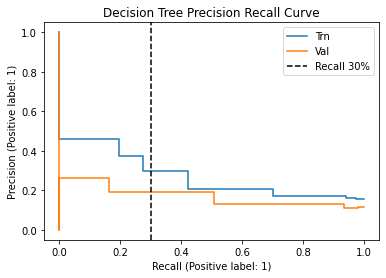

In [20]:
precision3, recall3, thresholds3 = precision_recall_curve(y_valid,valid_proba1[2])
precision3_t, recall3_t, thresholds3_t = precision_recall_curve(y_train,train_proba1[2])
plt.figure()
ax =plt.gca()
PrecisionRecallDisplay.from_predictions(y_train,train_proba1[4], ax=ax,label="Trn")
PrecisionRecallDisplay.from_predictions(y_valid,valid_proba1[4], ax=ax,label="Val")

plt.title("Decision Tree Precision Recall Curve")
#precision_at_recall2 = np.interp(x= 0.3,xp = precision2[int(0.1*len(recall2)):int(0.8*len(recall2))],fp = recall2[int(0.1*len(recall2)):int(0.8*len(recall2))])
precision_at_recall3 = np.interp(x= 0.3,fp = precision3,xp = recall3)
precision_at_recall3_t = np.interp(x= 0.3,fp = precision3_t,xp = recall3_t)
#plt.axhline(precision_at_recall3,color='green',linestyle = '--',label = f"Precision at Recall-Val 30% = 20%")
#plt.axhline(precision_at_recall3_t,color='green',linestyle = '--',label = f"Precision at Recall-Trn 30% = 20%")
plt.axvline(0.3,color='black',linestyle='--',label = 'Recall 30%')
plt.legend()
plt.show()

The model with student based features only is still at the baseline levels. 

## <font color = 'cornflowerblue' size=4>Ensemble models</font>

### <font color = 'cornflowerblue' size=3>XGBoost</font>

In [43]:
from xgboost import XGBClassifier


XGB_model = XGBClassifier(num_feature = 80,subsample = 0.01,max_depth=2)
XGB_model.fit(Xq2_train_mm,yq2train)
print(f"XG Boost train set score: {XGB_model.score(Xq2_train_mm,yq2train)}")
print(f"XG Boost val set score: {XGB_model.score(Xq2_valid_mm,yq2valid)}")

XG Boost train set score: 0.8475971977549265
XG Boost val set score: 0.8854166666666666


In [44]:
yq2_train_preds_probs_xgb = XGB_model.predict_proba(Xq2_train_mm)[:,1]
yq2_valid_preds_probs_xgb = XGB_model.predict_proba(Xq2_valid_mm)[:,1]


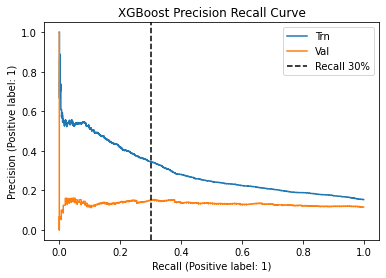

In [45]:
# calculating precision, recall and thresholds for the model
precision3, recall3, thresholds3 = precision_recall_curve(yq2valid, yq2_valid_preds_probs_xgb)
precision3_t, recall3_t, thresholds3_t = precision_recall_curve(yq2train, yq2_train_preds_probs_xgb)


# plotting precision recall curve and calling out precision at 30% recall
plt.figure()
ax =plt.gca()
# plotting precision-recall curve
PrecisionRecallDisplay.from_predictions(yq2train,yq2_train_preds_probs_xgb, ax=ax,label="Trn")
PrecisionRecallDisplay.from_predictions(yq2valid,yq2_valid_preds_probs_xgb, ax=ax,label="Val")

plt.title("XGBoost Precision Recall Curve")

# interpolating to find precision at recall = 30%
precision_at_recall3 = np.interp(x= 0.3,xp = precision3,fp = recall3)
precision_at_recall3_t = np.interp(x= 0.3,xp = precision3_t,fp = recall3_t)

# plotting vertical line for recall = 0.3
plt.axvline(0.3,color='black',linestyle='--',label = 'Recall 30%')

# plotting horizontal line for precision at recall = 0.3, label with rounded precision number
#plt.axhline(precision_at_recall3,color='green',linestyle = '--',label = f"Precision at Recall 30% = {np.around(precision_at_recall2*100,2)}%")

plt.legend()
plt.show()

The XGBoost model is overfitting to the training set.

In [46]:
XGB_feature_importances = pd.Series(XGB_model.feature_importances_,index=Xq2train.columns)
XGB_feature_importances.sort_values(ascending=False).head(20)

avg_history_frac            0.110342
avgdelta_day                0.104923
history_frac                0.101052
L_dist_sf_noaccents_norm    0.093973
numwordspracticed_day       0.093346
history_seen                0.092366
EnglishIDF                  0.087783
sf_length                   0.087009
delta                       0.084676
avgp_forgot_day             0.079625
simoverdiff                 0.064904
dtype: float32

Ensemble techniques show a slight improvement in precision in the zone where recall is low. It is training to specific cases, possibly for a certain predictable set of students. 

## <font color='cornflowerblue' size=4>Neural nets</font>

In [47]:
#!nvidia-smi
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [48]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [49]:
!cat /usr/local/lib/python3.6/dist-packages/external/local_config_cuda/cuda/cuda/cuda_config.h |\
grep TF_CUDA_VERSION

cat: /usr/local/lib/python3.6/dist-packages/external/local_config_cuda/cuda/cuda/cuda_config.h: No such file or directory


In [50]:
from tensorflow import keras
from tensorflow.keras import layers

In [51]:
# Create a new sequential model
model = tf.keras.Sequential()

regularizer = keras.regularizers.l2(0.001)

# Declare the hidden layers
model.add(layers.Dense(11, activation="relu",kernel_regularizer=regularizer))
model.add(layers.Dense(4, activation="relu",kernel_regularizer=regularizer))

# Declare the output layer
model.add(layers.Dense(1, activation="sigmoid"))

In [52]:
model.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(),  
    # Loss function to minimize
     
    loss=keras.losses.BinaryCrossentropy(),
    # Metric used to evaluate model
    metrics=[tf.keras.metrics.PrecisionAtRecall(recall=0.3)]
)

In [53]:
history = model.fit(Xq2_train_mm,np.array(yq2train), epochs=20, verbose=1, batch_size=500,validation_data = (Xq2_valid_mm,np.array(yq2valid)))

Epoch 1/20
49/49 [==============================] - 4s 8ms/step - loss: 0.5567 - precision_at_recall: 0.1535 - val_loss: 0.4667 - val_precision_at_recall: 0.1152
Epoch 2/20
49/49 [==============================] - 0s 3ms/step - loss: 0.4586 - precision_at_recall: 0.2067 - val_loss: 0.3788 - val_precision_at_recall: 0.1518
Epoch 3/20
49/49 [==============================] - 0s 4ms/step - loss: 0.4250 - precision_at_recall: 0.3076 - val_loss: 0.3720 - val_precision_at_recall: 0.1523
Epoch 4/20
49/49 [==============================] - 0s 3ms/step - loss: 0.4194 - precision_at_recall: 0.3153 - val_loss: 0.3694 - val_precision_at_recall: 0.1579
Epoch 5/20
49/49 [==============================] - 0s 3ms/step - loss: 0.4166 - precision_at_recall: 0.3210 - val_loss: 0.3658 - val_precision_at_recall: 0.2041
Epoch 6/20
49/49 [==============================] - 0s 3ms/step - loss: 0.4150 - precision_at_recall: 0.3326 - val_loss: 0.3643 - val_precision_at_recall: 0.2190
Epoch 7/20
49/49 [==========

In [54]:
history.history.keys()

dict_keys(['loss', 'precision_at_recall', 'val_loss', 'val_precision_at_recall'])

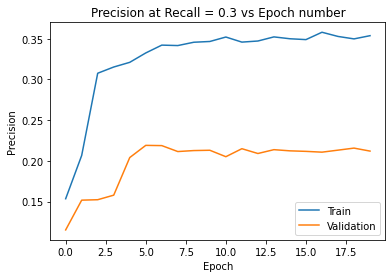

In [55]:
plt.plot(history.history['precision_at_recall'])
plt.plot(history.history['val_precision_at_recall'])
plt.title('Precision at Recall = 0.3 vs Epoch number')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

The model's features do not seem to predict unseen students with as much accuracy as the training set, although it does do better in precision that the 0.11 if it were to guess at everything as 1. 

The next round of modeling will get rid of all word based features to do an apples-to-apples comparison with student based features only.

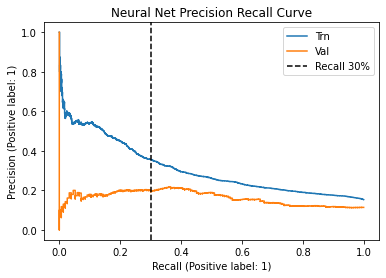

In [56]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
yq2_valid_preds_probs_nn = model.predict(Xq2_valid_mm)
yq2_train_preds_probs_nn = model.predict(Xq2_train_mm)

# calculating precision, recall and thresholds for the model
precision3, recall3, thresholds3 = precision_recall_curve(yq2valid, yq2_valid_preds_probs_nn)
precision3_t, recall3_t, thresholds3_t = precision_recall_curve(yq2train, yq2_train_preds_probs_nn)


# plotting precision recall curve and calling out precision at 30% recall
plt.figure()
ax =plt.gca()
# plotting precision-recall curve
PrecisionRecallDisplay.from_predictions(yq2train,yq2_train_preds_probs_nn, ax=ax,label="Trn")
PrecisionRecallDisplay.from_predictions(yq2valid,yq2_valid_preds_probs_nn, ax=ax,label="Val")

plt.title("Neural Net Precision Recall Curve")

# interpolating to find precision at recall = 30%
#precision_at_recall3 = np.interp(x= 0.3,fp = precision3,xp = recall3)
#precision_at_recall3_t = np.interp(x= 0.3,xp = precision3_t,fp = recall3_t)

# plotting vertical line for recall = 0.3
plt.axvline(0.3,color='black',linestyle='--',label = 'Recall 30%')

# plotting horizontal line for precision at recall = 0.3, label with rounded precision number
#plt.axhline(precision_at_recall3,color='green',linestyle = '--',label = f"Precision at Recall 30% = {np.around(precision_at_recall3*100,2)}%")

plt.legend()
plt.show()